# Koopman Seq2Seq model

[work in progress]

Here I develop a new ML architecture, combining Koopman kernel methods with a seq2seq architecture.

In [1]:
import os
import random
import time

import numpy as np
import torch
from absl import app
# from klearn_tcyclone.training_utils.args import FLAGS, ALL_FLAGS
from klearn_tcyclone.training_utils.training_utils import get_default_flag_values
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils import data

from klearn_tcyclone.climada.tc_tracks import TCTracks
from klearn_tcyclone.data_utils import (
    LinearScaler,
)
from klearn_tcyclone.KNF.modules.eval_metrics import RMSE_TCTracks
from klearn_tcyclone.KNF.modules.models import Koopman
from klearn_tcyclone.KNF.modules.train_utils import (
    eval_epoch_koopman,
    train_epoch_koopman,
)
from klearn_tcyclone.knf_data_utils import TCTrackDataset
from klearn_tcyclone.training_utils.training_utils import set_flags
from absl import app, flags

from klearn_tcyclone.training_utils.training_utils import extend_by_default_flag_values

from klearn_tcyclone.koopkernel_seq2seq import KoopmanKernelSeq2Seq, RBFKernel
from klearn_tcyclone.koopkernel_seq2seq import KoopKernelLoss, batch_tensor_context


In [2]:
from klearn_tcyclone.data_utils import (
    load_model,
    standardized_context_dataset_from_TCTracks,
)

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from matplotlib import pyplot as plt


from matplotlib import pyplot as plt
import copy
from matplotlib.axes._axes import Axes

from klearn_tcyclone.KNF.modules.models import Koopman
import torch

In [ ]:
def train_one_epoch(model: KoopmanKernelSeq2Seq, optimizer, loss_fun, scheduler, epoch_index, tb_writer, tensor_context_inps, tensor_context_tgts):
    """From https://pytorch.org/tutorials/beginner/introyt/trainingyt.html."""

    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting

    print(range(tensor_context_inps.shape[1]))
    for i in range(tensor_context_inps.shape[1]):

        # Every data instance is an input + label pair
        inputs, labels = tensor_context_inps[:,i], tensor_context_tgts[:,i]
        if model.context_mode == "last_context":
            labels = labels[:, -1, :]

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fun(outputs, labels)
        loss.backward()

        # print(loss.item())

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 10 == 9:
            last_loss = running_loss / 10 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * tensor_context_inps.shape[1] + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    
    print(optimizer.state_dict()["param_groups"][0])

    scheduler.step()

    return last_loss

## Import data

Set some specific parameters and load default values for all other parameters.

In [3]:
flag_params = {
    # "seed": 42,
    "year_range": [1980, 1988],
    # "batch_size": 16,
    "num_epochs": 20,
    "train_output_length": 1,
    "test_output_length": 1,
    "input_length": 13,
    "context_length": 14,
}
flag_params = extend_by_default_flag_values(flag_params)

assert flag_params["context_length"] == flag_params["input_length"] + flag_params["train_output_length"]

In [4]:
random.seed(flag_params["seed"])  # python random generator
np.random.seed(flag_params["seed"])  # numpy random generator

torch.manual_seed(flag_params["seed"])
torch.cuda.manual_seed_all(flag_params["seed"])

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

feature_list = [
    "lon",
    "lat",
    "max_sustained_wind",
    # "radius_max_wind",
    # "radius_oci",
    "central_pressure",
    "environmental_pressure",
]

# feature_list = [
#     "lon",
#     "lat",
#     "max_sustained_wind",
#     "radius_max_wind",
#     "radius_oci",
#     "central_pressure",
#     "environmental_pressure",
# ]

# these are not contained as flags
# encoder_hidden_dim = flag_params["hidden_dim"]
# decoder_hidden_dim = flag_params["hidden_dim"]
# encoder_num_layers = flag_params["num_layers"]
# decoder_num_layers = flag_params["num_layers"]

output_dim = flag_params["input_dim"]
num_feats = len(feature_list)
learning_rate = flag_params["learning_rate"]
# ---------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device", device)

scaler = LinearScaler()
eval_metric = RMSE_TCTracks

Device cuda


In [5]:
# Datasets
tc_tracks = TCTracks.from_ibtracs_netcdf(
    provider="official",
    year_range=flag_params["year_range"],
    basin="NA",
)

tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)

2025-02-16 20:10:10,834 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /home/ecjb/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2025-02-16 20:12:41,031 - climada.hazard.tc_tracks - WARNING - 49 storm events are discarded because no valid wind/pressure values have been found: 1980199N31284, 1980200N25270, 1980204N23287, 1980226N15339, 1980238N16328, ...


/home/ecjb/packages/climada_python/climada/hazard/tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


In [6]:
len(tc_tracks_train), tc_tracks_train[5]

(73,
 <xarray.Dataset> Size: 8kB
 Dimensions:                 (time: 134)
 Coordinates:
   * time                    (time) datetime64[ns] 1kB 1986-08-13T12:00:00 ......
     lat                     (time) float32 536B 30.1 30.45 30.8 ... 56.2 56.2
     lon                     (time) float32 536B -84.0 -84.0 -84.0 ... 7.0 8.0
 Data variables:
     radius_max_wind         (time) float32 536B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
     radius_oci              (time) float32 536B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
     max_sustained_wind      (time) float32 536B 10.0 10.0 10.0 ... 15.0 15.0
     central_pressure        (time) float32 536B 1.009e+03 1.01e+03 ... 1.006e+03
     environmental_pressure  (time) float64 1kB 1.01e+03 1.01e+03 ... 1.01e+03
     time_step               (time) float64 1kB 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0
     basin                   (time) <U2 1kB 'NA' 'NA' 'NA' ... 'NA' 'NA' 'NA'
 Attributes:
     max_sustained_wind_unit:  kn
     central_pressure_unit:    mb
     orig_event

In [7]:
time_lag = 1
scaler = LinearScaler()
basin = "NA"

The idea is to feed the tensor_context_dataset into the model. Because for the kernels I need the lookback window and the shifted version of this.

In [8]:
tensor_context_train_standardized = standardized_context_dataset_from_TCTracks(
    tc_tracks_train,
    feature_list=feature_list,
    scaler=scaler,
    context_length=flag_params["context_length"],
    time_lag=time_lag,
    fit=True,
    periodic_shift=True,
    basin=basin,
)

con_len set to context_length.


In [9]:
tensor_context_train_standardized.shape

(3301, 14, 5)

In [10]:
flag_params["context_length"]

14

In [11]:
flag_params["input_length"], flag_params["train_output_length"]

(13, 1)

In [12]:
train_set = TCTrackDataset(
    input_length=flag_params["input_length"],
    output_length=flag_params["train_output_length"],
    tc_tracks=tc_tracks_train,
    feature_list=feature_list,
    mode="train",
    jumps=flag_params["jumps"],
    scaler=scaler,
    fit=True,
)
valid_set = TCTrackDataset(
    input_length=flag_params["input_length"],
    output_length=flag_params["train_output_length"],
    tc_tracks=tc_tracks_train,
    feature_list=feature_list,
    mode="valid",
    jumps=flag_params["jumps"],
    scaler=scaler,
    fit=False,
)
test_set = TCTrackDataset(
    input_length=flag_params["input_length"],
    output_length=flag_params["test_output_length"],
    tc_tracks=tc_tracks_test,
    feature_list=feature_list,
    mode="test",
    # jumps=flag_params["jumps"], # jumps not used in test mode
    scaler=scaler,
    fit=False,
)
train_loader = data.DataLoader(
    train_set, batch_size=flag_params["batch_size"], shuffle=True, num_workers=1
)
valid_loader = data.DataLoader(
    valid_set, batch_size=flag_params["batch_size"], shuffle=True, num_workers=1
)
test_loader = data.DataLoader(
    test_set, batch_size=flag_params["batch_size"], shuffle=False, num_workers=1
)

if len(train_loader) == 0:
    raise Exception(
        "There are likely too few data points in the test set. Try to increase year_range."
    )

Check why we have nan values!!!

In [13]:
counter = 0
for inps, tgts in train_loader:
    if counter < 5:
        print(counter)
        print(inps.shape, type(inps))
        print(tgts.shape, type(inps))
        print(inps[0,:,0])
        print(tgts[0,:,0])
        print()
    
    counter += 1


0
torch.Size([32, 13, 5]) <class 'torch.Tensor'>
torch.Size([32, 1, 5]) <class 'torch.Tensor'>
tensor([-0.3270, -0.3238, -0.3222, -0.3143, -0.3064, -0.2969, -0.2874, -0.2795,
        -0.2573, -0.2352, -0.2177, -0.2003, -0.1742])
tensor([-0.1481])

1
torch.Size([32, 13, 5]) <class 'torch.Tensor'>
torch.Size([32, 1, 5]) <class 'torch.Tensor'>
tensor([-0.0808, -0.0768, -0.0752, -0.0736, -0.0744, -0.0752, -0.0776, -0.0800,
        -0.0863, -0.0926, -0.0982, -0.1037, -0.1093])
tensor([-0.1148])

2
torch.Size([32, 13, 5]) <class 'torch.Tensor'>
torch.Size([32, 1, 5]) <class 'torch.Tensor'>
tensor([0.6120, 0.6239, 0.6358, 0.6397, 0.6437, 0.6477, 0.6516, 0.6714, 0.6912,
        0.7189, 0.7466, 0.7625, 0.7783])
tensor([0.7862])

3
torch.Size([32, 13, 5]) <class 'torch.Tensor'>
torch.Size([32, 1, 5]) <class 'torch.Tensor'>
tensor([-0.1433, -0.1489, -0.1544, -0.1591, -0.1639, -0.1686, -0.1734, -0.1774,
        -0.1813, -0.1845, -0.1876, -0.1892, -0.1908])
tensor([-0.1916])

4
torch.Size([32, 13, 

In [14]:
tensor_context_train_standardized.data.shape

(3301, 14, 5)

In [15]:
flag_params["input_length"], flag_params["train_output_length"]

(13, 1)

In [16]:
tensor_context_inps, tensor_context_tgts = batch_tensor_context(
    tensor_context_train_standardized,
    batch_size=flag_params["batch_size"],
    input_length=flag_params["input_length"],
    output_length=flag_params["train_output_length"],
)
assert torch.all(tensor_context_inps[:,:,1:] == tensor_context_tgts[:,:,:-1])
tensor_context_inps.shape, tensor_context_tgts.shape

(torch.Size([32, 103, 13, 5]), torch.Size([32, 103, 13, 5]))

In [17]:
m = nn.Dropout(p=0.2)
input = torch.randn(12, 4)
# output = input
output = m(input)

In [18]:
output

tensor([[ 0.0000, -1.4180, -1.5607, -0.0000],
        [ 0.8854,  1.0389,  0.3996, -1.2018],
        [ 0.6969,  0.0000, -0.4411,  0.0000],
        [-0.4754,  1.0791, -0.5748, -2.1081],
        [-0.9038,  0.4996, -1.5146, -1.4703],
        [ 0.3719, -0.0000, -2.0920,  1.0250],
        [-1.4110,  0.0000,  0.0815,  0.0483],
        [ 0.4959,  0.1266,  0.8658,  1.3709],
        [ 0.6611,  0.0000, -0.3912,  0.0000],
        [ 0.0000,  1.1273, -0.7555,  1.7286],
        [-1.8233,  0.6153,  0.0000,  0.0000],
        [ 1.3718,  0.0000, -1.1233,  1.7907]])

### Single step model

In [ ]:
flag_params["koopman_kernel_num_centers"] = 1000

In [ ]:
def train_KKSeq2Seq(num_epochs, context_mode) -> tuple[KoopmanKernelSeq2Seq, list]:

    if flag_params["train_output_length"] != 1:
        raise Exception("This function still requires output_length = 1.")
    
    rbf = RBFKernel(length_scale=1E-1)

    #TODO some parameters don't play a role in model definition -> remove them
    koopkernelmodel = KoopmanKernelSeq2Seq(
        kernel=rbf,
        input_dim = num_feats,
        input_length = flag_params["input_length"],
        output_length = flag_params["train_output_length"],
        output_dim = 1,
        num_steps = 1,
        num_nys_centers = flag_params["koopman_kernel_num_centers"],
        rng_seed = 42,
        context_mode=context_mode,
    )

    koopkernelmodel._initialize_nystrom_data(tensor_context_train_standardized)


    optimizer = torch.optim.Adam(koopkernelmodel.parameters(), lr=learning_rate)
    loss_koopkernel = KoopKernelLoss(koopkernelmodel.nystrom_data_Y, koopkernelmodel._kernel)

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    tb_writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=1, gamma=flag_params["decay_rate"]
    )  # stepwise learning rate decay


    epoch_index = 1
    train_loss = []
    for epoch_index, epoch in enumerate(range(num_epochs)):
        train_loss.append(train_one_epoch(koopkernelmodel, optimizer, loss_koopkernel, scheduler, epoch_index, tb_writer, tensor_context_inps, tensor_context_tgts))
    

    return koopkernelmodel, train_loss

In [ ]:
rbf = RBFKernel(length_scale=1E-1)

#TODO some parameters don't play a role in model definition -> remove them
koopkernelmodel = KoopmanKernelSeq2Seq(
    kernel=rbf,
    input_dim = num_feats,
    input_length = 13,
    output_length = 1,
    output_dim = 1,
    num_steps = 1,
    num_nys_centers = flag_params["koopman_kernel_num_centers"],
    rng_seed = 42,
    # context_mode="last_context"
    # context_mode="no_context"
    context_mode="full_context"
)

koopkernelmodel._initialize_nystrom_data(tensor_context_train_standardized)

torch.Size([1000, 5]) torch.Size([1000, 5])


#### Compare context modes

In [189]:
context_modes = [
    # "no_context",
    "full_context",
    # "last_context",
]
models = {}
train_losses = {}
for cm in context_modes:
    m, tl = train_KKSeq2Seq(flag_params["num_epochs"], cm)
    models[cm] = m
    train_losses[cm] = tl

torch.Size([1000, 5]) torch.Size([1000, 5])
range(0, 103)
  batch 10 loss: 0.2699535548686981
  batch 20 loss: 0.24510035961866378
  batch 30 loss: 0.2211139276623726
  batch 40 loss: 0.19808569997549058
  batch 50 loss: 0.15121935978531836
  batch 60 loss: 0.11774655357003212
  batch 70 loss: 0.118960652500391
  batch 80 loss: 0.09800691455602646
  batch 90 loss: 0.07945370860397816
  batch 100 loss: 0.07415060065686703
{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'initial_lr': 0.001, 'params': [0]}
range(0, 103)
  batch 10 loss: 0.0721783060580492
  batch 20 loss: 0.06536770090460778
  batch 30 loss: 0.08069838285446167
  batch 40 loss: 0.07464696429669856
  batch 50 loss: 0.06820722743868828
  batch 60 loss: 0.06685983240604401
  batch 70 loss: 0.08499105758965016
  batch 80 loss: 0.06783822216093541
  batch 90 loss: 0.08012386187911033
  batch 

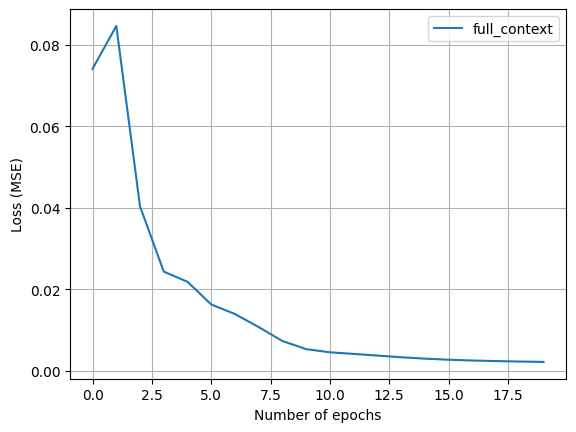

In [190]:
fig, ax = plt.subplots()

for idx, cm in enumerate(context_modes):
    ax.plot(range(flag_params["num_epochs"]), train_losses[cm], color = f"C{idx}", label = cm)
# ax.set_yscale("log")
ax.set_xlabel("Number of epochs")
ax.set_ylabel("Loss (MSE)")
ax.legend()
ax.grid()

# save_path = os.path.join(
#     "../plots/", "koopman_seq2seq/"
# )
# os.makedirs(save_path, exist_ok=True)
# fig.savefig(os.path.join(save_path, "context_mode_comparison.png"), bbox_inches='tight')

#### Plot predictions

In [119]:
"""Utils for Koopman model."""

from klearn_tcyclone.plot_utils import plot_TCTrackDataset_item_2D


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def predict_koopman_seq2seq_model(
    time_series: torch.Tensor,
    prediction_steps: int,
    model: KoopmanKernelSeq2Seq,
):
    assert len(time_series.shape) == 2
    # tgts_dummy only needed to set the number of predicted time steps by model.
    """
    Note: The model performs a number of single_forward steps, each predicting
    `num_steps` future time steps, such that the total number of predicted time steps is
    larger than `tgts.shape[1]`, i.e. `prediction_steps` or the `output_length` of the
    dataset. In the end only the first `output_length` predicted data points are given
    as output, the remaining (further) steps are discarded.
    """
    if model.context_mode == "no_context":
        time_series_unsqueeze = time_series.unsqueeze(0).to(device)
    elif model.context_mode == "full_context":
        time_series_unsqueeze = time_series[-model.input_length:].unsqueeze(0).to(device)
    if model.context_mode == "last_context":
        time_series_unsqueeze = time_series[-model.input_length:].unsqueeze(0).to(device)
    # outs_list = []
    prediction = time_series_unsqueeze
    # outs_list.append(prediction)
    for _ in range(prediction_steps):
        new_prediction = model(prediction)
        if model.context_mode == "last_context":
            new_prediction = new_prediction.unsqueeze(1).to(device)
            prediction = torch.cat([prediction[:,1:], new_prediction], dim=1)
        else:
            prediction = torch.cat([prediction[:,1:], new_prediction[:,-1:]], dim=1)
        # outs_list.append(prediction)

    res = prediction[0,-prediction_steps:]
    return res


def plot_TCTrackDataset_item_2D_with_prediction_koopman_seq2seq(
    tc_tracks_dataset: TCTrackDataset,
    idx: int,
    prediction_steps,
    model,
    ax: Axes,
    color: str,
    dimensions: tuple[int, int] = (0, 1),
):
    plot_TCTrackDataset_item_2D(tc_tracks_dataset, idx, ax, color, dimensions)
    time_series, _ = tc_tracks_dataset[idx]
    predictions = predict_koopman_seq2seq_model(
        time_series, prediction_steps, model
    )
    predictions = predictions.cpu().data.numpy()
    ax.plot(
        predictions[:, dimensions[0]],
        predictions[:, dimensions[1]],
        marker="s",
        color=color,
    )


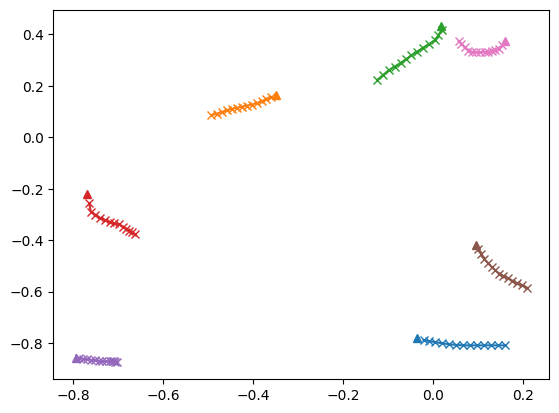

In [120]:
fig, ax = plt.subplots()
for i, idx in enumerate(np.random.randint(0, len(train_set), 7)):
    plot_TCTrackDataset_item_2D(train_set, idx, ax, color=f"C{i}")

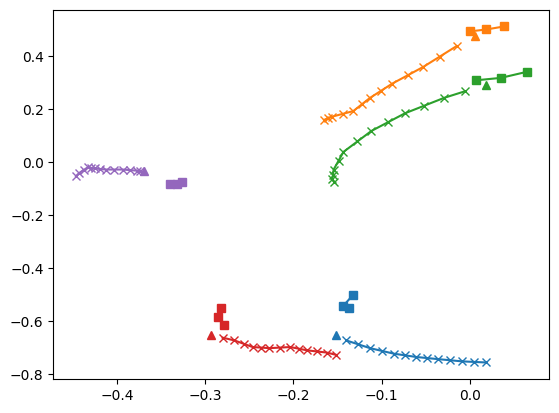

In [121]:
prediction_steps = 3

fig, ax = plt.subplots()
for i, idx in enumerate(np.random.randint(0, len(train_set), 5)):

    plot_TCTrackDataset_item_2D_with_prediction_koopman_seq2seq(
        train_set,
        idx,
        prediction_steps=prediction_steps,
        model=models["last_context"],
        ax=ax,
        color=f"C{i}"
    )

# ax.set_xlim(-1, 1)
# ax.set_ylim(-1, 1)
# ax.set_xlim(-6,-5)
# ax.set_ylim(-9.25,-9)

### Multi step model

In [102]:
flag_params["input_length"] = 13
flag_params["train_output_length"] = 1
flag_params["context_length"] = flag_params["input_length"] + flag_params["train_output_length"]
flag_params["num_epochs"] = 10
flag_params["koopman_kernel_num_centers"] = 50
# flag_params["koopman_kernel_num_centers"] = 1000

In [ ]:
def train_KKSeq2Seq(num_epochs, context_mode, input_length, output_length):

    rbf = RBFKernel(length_scale=1E-1)

    #TODO some parameters don't play a role in model definition -> remove them
    koopkernelmodel = KoopmanKernelSeq2Seq(
        kernel=rbf,
        input_dim = num_feats,
        input_length = input_length,
        output_length = output_length,
        output_dim = 1,
        num_steps = 1,
        num_nys_centers = flag_params["koopman_kernel_num_centers"],
        rng_seed = 42,
        context_mode=context_mode,
    )

    koopkernelmodel._initialize_nystrom_data(tensor_context_train_standardized)

    optimizer = torch.optim.Adam(koopkernelmodel.parameters(), lr=learning_rate)
    loss_koopkernel = KoopKernelLoss(koopkernelmodel.nystrom_data_Y, koopkernelmodel._kernel)

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    tb_writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=1, gamma=flag_params["decay_rate"]
    )  # stepwise learning rate decay


    epoch_index = 1
    train_loss = []
    for epoch_index, epoch in enumerate(range(num_epochs)):
        train_loss.append(train_one_epoch(koopkernelmodel, optimizer, loss_koopkernel, scheduler, epoch_index, tb_writer, tensor_context_inps, tensor_context_tgts))
    

    return koopkernelmodel, train_loss

In [103]:
tensor_context_train_standardized = standardized_context_dataset_from_TCTracks(
    tc_tracks_train,
    feature_list=feature_list,
    scaler=scaler,
    context_length=flag_params["context_length"],
    time_lag=time_lag,
    fit=True,
    periodic_shift=True,
    basin=basin,
    input_length=flag_params["input_length"],
    output_length=flag_params["train_output_length"],
)

intput_length and output_length are not None.


In [104]:
tensor_context_train_standardized.shape

(3301, 14, 5)

In [105]:
tensor_context_inps, tensor_context_tgts = batch_tensor_context(
    tensor_context_train_standardized,
    batch_size=flag_params["batch_size"],
    input_length=flag_params["input_length"],
    output_length=flag_params["train_output_length"],
)


In [106]:
for idx in range(flag_params["train_output_length"]):
    if flag_params["train_output_length"] == 1:
        assert torch.all(tensor_context_inps[:,:,idx+1:] == tensor_context_tgts[:,:,:-idx-1])
    else:
        assert torch.all(tensor_context_inps[:,:,idx+1:] == tensor_context_tgts[:,:,:-idx-1,idx])
tensor_context_inps.shape, tensor_context_tgts.shape

(torch.Size([32, 103, 13, 5]), torch.Size([32, 103, 13, 5]))

In [107]:
rbf = RBFKernel(length_scale=1E-1)

#TODO some parameters don't play a role in model definition -> remove them
koopkernelmodel = KoopmanKernelSeq2Seq(
    kernel=rbf,
    input_dim = num_feats,
    input_length = flag_params["input_length"],
    output_length = flag_params["train_output_length"],
    output_dim = 1,
    num_steps = 1,
    num_nys_centers = flag_params["koopman_kernel_num_centers"],
    rng_seed = 42,
    # context_mode="last_context"
    # context_mode="no_context"
    context_mode="full_context"
)

koopkernelmodel._initialize_nystrom_data(tensor_context_train_standardized)

torch.Size([50, 5]) torch.Size([50, 5])


#### Compare context modes

In [114]:
# context_modes = [
#     "no_context",
#     "full_context",
#     "last_context",
# ]
# models = {}
# train_losses = {}
# for cm in context_modes:
#     m, tl = train_KKSeq2Seq(flag_params["num_epochs"], cm)
#     models[cm] = m
#     train_losses[cm] = tl


# context_mode = "last_context"
context_mode = "full_context"
model, train_loss = train_KKSeq2Seq(
    flag_params["num_epochs"],
    context_mode=context_mode,
    input_length=flag_params["input_length"],
    output_length=flag_params["train_output_length"],
)

torch.Size([50, 5]) torch.Size([50, 5])
range(0, 103)
  batch 10 loss: 0.40187968611717223
  batch 20 loss: 0.36520738899707794
  batch 30 loss: 0.34150153398513794
  batch 40 loss: 0.3103699326515198
  batch 50 loss: 0.3018503040075302
  batch 60 loss: 0.2941481202840805
  batch 70 loss: 0.2634649470448494
  batch 80 loss: 0.2553233698010445
  batch 90 loss: 0.23790010958909988
  batch 100 loss: 0.2319407656788826
{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'initial_lr': 0.001, 'params': [0]}
range(0, 103)
  batch 10 loss: 0.24698455780744552
  batch 20 loss: 0.23727424144744874
  batch 30 loss: 0.23299562633037568
  batch 40 loss: 0.21551116555929184
  batch 50 loss: 0.21544323712587357
  batch 60 loss: 0.2298417791724205
  batch 70 loss: 0.20657221376895904
  batch 80 loss: 0.2138778567314148
  batch 90 loss: 0.20272877514362336
  batch 100 los

In [115]:
train_loss

[0.2319407656788826,
 0.19637762159109115,
 0.18292969316244126,
 0.17527609020471574,
 0.17010859698057174,
 0.16629122346639633,
 0.16332028359174727,
 0.16093436181545256,
 0.15897853225469588,
 0.1573513299226761]

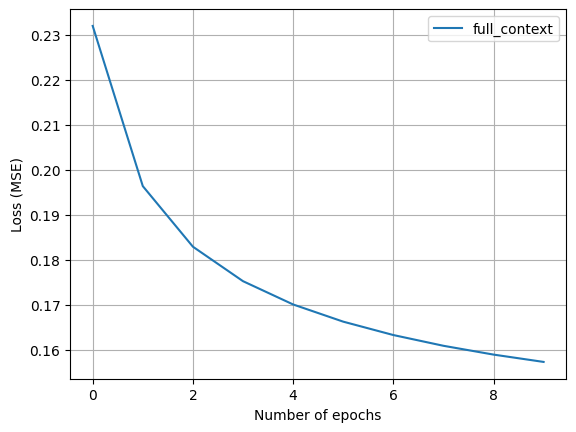

In [116]:
fig, ax = plt.subplots()

ax.plot(range(flag_params["num_epochs"]), train_loss, color = f"C{0}", label = "full_context")
# ax.set_yscale("log")
ax.set_xlabel("Number of epochs")
ax.set_ylabel("Loss (MSE)")
ax.legend()
ax.grid()

# save_path = os.path.join(
#     "../plots/", "koopman_seq2seq/"
# )
# os.makedirs(save_path, exist_ok=True)
# fig.savefig(os.path.join(save_path, "context_mode_comparison.png"), bbox_inches='tight')

#### Plot predictions

In [135]:
"""Utils for Koopman model."""

from klearn_tcyclone.plot_utils import plot_TCTrackDataset_item_2D


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def predict_koopman_seq2seq_model(
    time_series: torch.Tensor,
    prediction_steps: int,
    model: KoopmanKernelSeq2Seq,
):
    assert len(time_series.shape) == 2
    # tgts_dummy only needed to set the number of predicted time steps by model.
    """
    Note: The model performs a number of single_forward steps, each predicting
    `num_steps` future time steps, such that the total number of predicted time steps is
    larger than `tgts.shape[1]`, i.e. `prediction_steps` or the `output_length` of the
    dataset. In the end only the first `output_length` predicted data points are given
    as output, the remaining (further) steps are discarded.
    """

    num_feats = time_series.shape[1]

    if model.context_mode == "no_context":
        time_series_unsqueeze = time_series.unsqueeze(0).to(device)
    elif model.context_mode == "full_context":
        time_series_unsqueeze = time_series[-model.input_length:].unsqueeze(0).to(device)
    if model.context_mode == "last_context":
        time_series_unsqueeze = time_series[-model.input_length:].unsqueeze(0).to(device)


    n_eval_steps = int(prediction_steps // model.output_length)
    if n_eval_steps * model.output_length < prediction_steps:
        n_eval_steps += 1

    predictions = torch.zeros(
        size=(
            n_eval_steps * model.output_length,
            num_feats,
        ),
        device=device,
        dtype=torch.float32,
    )
    prediction = time_series_unsqueeze
    # shape: (1, input_length, num_feats)
    print(prediction.shape)

    for idx in range(n_eval_steps):
        new_prediction = model(prediction)
        if model.context_mode == "last_context":
            if model.output_length == 1:
                new_prediction = new_prediction.unsqueeze(1)
            prediction = torch.cat([prediction[:, model.output_length:], new_prediction], dim=1)
            # shape: (1, input_length, num_feats)
        else:
            if model.output_length == 1:
                new_prediction = new_prediction.unsqueeze(2)
            prediction = torch.cat([prediction[:, model.output_length:], new_prediction[:, -1]], dim=1)
            # shape: (1, input_length, num_feats)
        print(prediction.shape)
        predictions[idx * model.output_length : (idx+1) * model.output_length] = prediction[0, -model.output_length:]
    # shape: (n_eval_steps, num_feats)

    print(predictions.shape)

    return predictions[:prediction_steps]


def plot_TCTrackDataset_item_2D_with_prediction_koopman_seq2seq(
    tc_tracks_dataset: TCTrackDataset,
    idx: int,
    prediction_steps,
    model,
    ax: Axes,
    color: str,
    dimensions: tuple[int, int] = (0, 1),
):
    plot_TCTrackDataset_item_2D(tc_tracks_dataset, idx, ax, color, dimensions)
    time_series, _ = tc_tracks_dataset[idx]
    predictions = predict_koopman_seq2seq_model(
        time_series, prediction_steps, model
    )
    predictions = predictions.cpu().data.numpy()
    ax.plot(
        predictions[:, dimensions[0]],
        predictions[:, dimensions[1]],
        marker="s",
        color=color,
    )


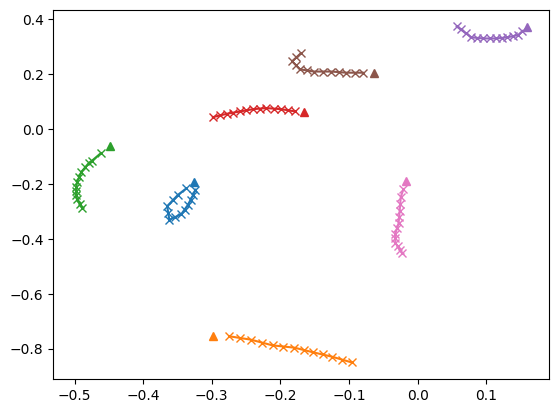

In [137]:
fig, ax = plt.subplots()
for i, idx in enumerate(np.random.randint(0, len(train_set), 7)):
    plot_TCTrackDataset_item_2D(train_set, idx, ax, color=f"C{i}")

torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([4, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([4, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([4, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([4, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([1, 13, 5])
torch.Size([4, 5])


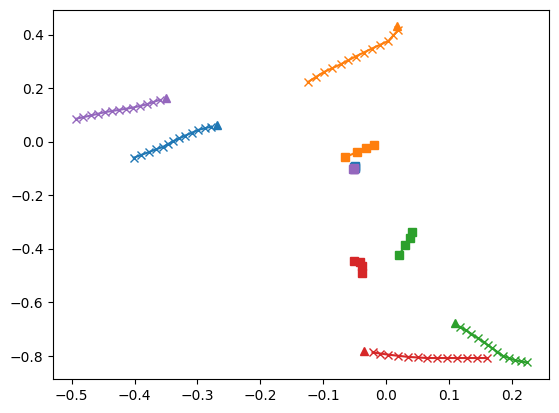

In [141]:
prediction_steps = 4

fig, ax = plt.subplots()
for i, idx in enumerate(np.random.randint(0, len(train_set), 5)):

    plot_TCTrackDataset_item_2D_with_prediction_koopman_seq2seq(
        train_set,
        idx,
        prediction_steps=prediction_steps,
        model=model,
        ax=ax,
        color=f"C{i}"
    )

# ax.set_xlim(-1, 1)
# ax.set_ylim(-1, 1)
# ax.set_xlim(-6,-5)
# ax.set_ylim(-9.25,-9)